## Приоритизация гипотез для интернет-магазина
В исследовании проанализированы данные подготовленные вместе с отделом маркетинга:

    1.Гипотезы: /datasets/hypothesis.csv
    2.Заказы: /datasets/orders_log.csv
    3.Визиты пользователей: /datasets/visitors.csv
    
Результатом исследования является выводы анализа А/В-теста и расставление приоритетов гипотез для увеличения выручки.

## Содержание анализа A/B-теста
_____

#### Подготовка:
* <a href="#step_1">1. Изучение файлов с данными, получение общей информации, загрузка библиотек.</a>
* <a href="#step_2">2. Предобработка данных.</a>

#### Приоритизация гипотез:
* <a id="fix_9" href="#step_3">3. Приоритизация ICE и RICE.</a>

#### Бизнес-метрики:
* * <a href="#step_41">4.1 Кумулятивная выручка по группам.</a>
* * <a href="#step_42">4.2 Кумулятивный средний чек по группам.</a>
* * <a href="#step_43">4.3 Относительное изменение кумулятивного среднего чека группы B к группе A.</a>
* * <a href="#step_44">4.4 Кумулятивная конверсия по группам.</a>
* * <a href="#step_45">4.5 Относительное изменение кумулятивной конверсии группы B к группе A.</a>

#### Точечные графики:
* * <a href="#step_56">5.1 Точечный график количества заказов по пользователям.</a>
* * <a href="#step_57">5.2 Перцентили количества заказов на пользователя.</a>
* * <a href="#step_58">5.3 Точечный график стоимостей заказов.</a>
* * <a href="#step_59">5.4 Перцентили стоимости заказов.</a>

#### Проверка гипотез:
* * <a href="#step_61">6.1 Статистическая значимость различий в конверсии между группами.</a>
* * <a href="#step_62">6.2 Статистическая значимость различий в среднем чеке заказа между группами.</a>
* * <a href="#step_63">6.3 Статистическая значимость различий в конверсии между «очищенными» группами.</a>
* * <a href="#step_64">6.4 Статистическая значимость различий в среднем чеке заказа между «очищенными» группами</a>

#### Итог:
* <a href="#step_7">Общий вывод</a>


<a id='step_11'></a>
### 1.1 Изучение файлов с данными, получение общей информации, загрузка библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import datetime as dt
from matplotlib.pyplot import figure

# Глобально снял ограничение на кол-во выводов для каждой ячейки ввода кода.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Включил возможность форматировать стили текста с помощью метода printmd()
from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))
    
# Снял ограничение на вывод кол-ва столбцов и ширины колонки.
pd.set_option('display.max_columns', None)
try:
    pd.set_option('display.max_colwidth', None)
except:
    pd.set_option('display.max_colwidth', -1)
    
# Добавил функцию вывода таблиц в одну строку, для экономии пространства и улучшения восприятия информации.
def display_side_by_side(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

# Сформировал датафреймы из csv файлов сразу отсеяв дубликапты.
hypothesis = pd.read_csv('/datasets/hypothesis.csv').drop_duplicates().reset_index(drop = True)
orders = pd.read_csv('/datasets/orders.csv').drop_duplicates().reset_index(drop = True)
visitors = pd.read_csv('/datasets/visitors.csv').drop_duplicates().reset_index(drop = True)

display_side_by_side(
    [orders.head(5),visitors.head(5),hypothesis.head(5)], 
    ['Заказы', 'Визиты','Гипотезы']
)

In [2]:
printmd('**Информация о заказах, orders:**')
orders.info()
print()
print()
printmd('**Информация о визитах, visitors:**')
visitors.info()
print()
print()
printmd('**Информация о гипотезах, hypothesis:**')
hypothesis.info()

**Информация о заказах, orders:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB




**Информация о визитах, visitors:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB




**Информация о гипотезах, hypothesis:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [3]:
# Вывел уникальные значения столбцов, для проверки корректности данных. 
# Применил try except для обхода ошибок сортировки. Сортировал значения там, где это возможно.
def check_unique(df):
    a = []
    for column in df.columns:
        datatype = df[column].dtypes
        print('{} ({}):'.format(column,datatype))
        try:
            a = df[column].unique()
            a.sort()
            with np.set_printoptions(formatter={'float_kind':'{:.2f}'.format}):
                print(a)
        except:
            print(a)

        print('Кол-во элементов: {} из {}'.format(df[column].count(),len(df)))
        print()
        
printmd('**orders:**')
check_unique(orders)
print()
print()
printmd('**visitors:**')
check_unique(visitors)
print()
print()
printmd('**hypothesis:**')
check_unique(hypothesis)

**orders:**

transactionId (int64):
[   1062393    4919758    7210578 ... 4281129020 4288552432 4293855558]
Кол-во элементов: 1197 из 1197

visitorId (int64):
[   5114589    6958315    8300375 ... 4279090005 4281247801 4283872382]
Кол-во элементов: 1197 из 1197

date (object):
['2019-08-01' '2019-08-02' '2019-08-03' '2019-08-04' '2019-08-05'
 '2019-08-06' '2019-08-07' '2019-08-08' '2019-08-09' '2019-08-10'
 '2019-08-11' '2019-08-12' '2019-08-13' '2019-08-14' '2019-08-15'
 '2019-08-16' '2019-08-17' '2019-08-18' '2019-08-19' '2019-08-20'
 '2019-08-21' '2019-08-22' '2019-08-23' '2019-08-24' '2019-08-25'
 '2019-08-26' '2019-08-27' '2019-08-28' '2019-08-29' '2019-08-30'
 '2019-08-31']
Кол-во элементов: 1197 из 1197

revenue (int64):
[     50      60      70      75      76      90     100     110     112
     120     130     150     160     165     170     172     190     240
     250     265     270     282     290     295     299     300     310
     320     340     350     359     360     370     380

**visitors:**

date (object):
['2019-08-01' '2019-08-02' '2019-08-03' '2019-08-04' '2019-08-05'
 '2019-08-06' '2019-08-07' '2019-08-08' '2019-08-09' '2019-08-10'
 '2019-08-11' '2019-08-12' '2019-08-13' '2019-08-14' '2019-08-15'
 '2019-08-16' '2019-08-17' '2019-08-18' '2019-08-19' '2019-08-20'
 '2019-08-21' '2019-08-22' '2019-08-23' '2019-08-24' '2019-08-25'
 '2019-08-26' '2019-08-27' '2019-08-28' '2019-08-29' '2019-08-30'
 '2019-08-31']
Кол-во элементов: 62 из 62

group (object):
['A' 'B']
Кол-во элементов: 62 из 62

visitors (int64):
[361 369 378 395 406 412 413 421 468 487 490 502 507 509 531 543 544 546
 560 575 577 581 594 595 609 610 617 619 621 628 644 646 650 654 655 656
 667 668 676 679 699 707 709 711 713 717 718 719 720 721 722 735 737 746
 748 756 769 770]
Кол-во элементов: 62 из 62





**hypothesis:**

Hypothesis (object):
['Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа'
 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей'
 'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов'
 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'
 'Запустить акцию, дающую скидку на товар в день рождения'
 'Запустить собственную службу доставки, что сократит срок доставки заказов'
 'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар'
 'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей'
 'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию']
Кол-во элементов: 9 из 9

Reach (int64):
[ 1  2  3  5  8 10]
Кол-во элементов: 9 из 9

Impact (int64):
[ 1  2  3  5  7  9 10]
Кол-во элементов: 9

### Вывод

##### Информация о заказах, orders:      
<table>
  <thead>
    <tr>
      <td style="text-align: left;"><b>id колонки</b></td>
      <td style="text-align: left;width:100%;"><b>Описание</b></td>
      <td><b>Кол-во непустых значений</b></td>
      <td><b>Тип данных</b></td>
      <td style="text-align: left;min-width:315px;"><b>Комментарий</b></td>
    </tr>
  </thead>
  <tr>
    <td style="text-align: left;">transactionId</td>
    <td style="text-align: left;">идентификатор заказа</td>
    <td>1197</td>
    <td>int64</td>
    <td style="text-align: left;">Изменить название колонки на `transaction_id`</td>
  </tr>    
  <tr>
    <td style="text-align: left;">visitorId</td>
    <td style="text-align: left;">идентификатор пользователя, совершившего заказ</td>
    <td>1197</td>
    <td>int64</td>
    <td style="text-align: left;">Изменить название колонки на `visitor_id`</td>
  </tr>
  <tr>
    <td style="text-align: left;">date</td>
    <td style="text-align: left;">дата, когда был совершён заказ</td>
    <td>1197</td>
    <td>object</td>
    <td style="text-align: left;">Тип должен быть datetime64.</td>
  </tr>
  <tr>
    <td style="text-align: left;">revenue</td>
    <td style="text-align: left;">выручка заказа</td>
    <td>1197</td>
    <td>int64</td>
    <td style="text-align: left;"></td>
  </tr>
  <tr>
    <td style="text-align: left;">group</td>
    <td style="text-align: left;">группа A/B-теста, в которую попал заказ</td>
    <td>1197</td>
    <td>object</td>
    <td style="text-align: left;"></td>
  </tr>
</table>

##### Информация о посещениях сайта, visitors:
<table>
  <thead>
    <tr>
      <td style="text-align: left;"><b>id колонки</b></td>
      <td style="text-align: left;width:100%;"><b>Описание</b></td>
      <td><b>Кол-во непустых значений</b></td>
      <td><b>Тип данных</b></td>
      <td style="text-align: left;min-width:315px;"><b>Комментарий</b></td>
    </tr>
  </thead>
  <tr>
    <td style="text-align: left;">date</td>
    <td style="text-align: left;">дата</td>
    <td>62</td>
    <td>object</td>
    <td style="text-align: left;">Тип должен быть datetime64.</td>
  </tr>
  <tr>
    <td style="text-align: left;">group</td>
    <td style="text-align: left;">группа A/B-теста</td>
    <td>62</td>
    <td>object</td>
    <td style="text-align: left;">Изменить название колонки на `end_ts`</td>
  </tr>
  <tr>
    <td style="text-align: left;">visitors</td>
    <td style="text-align: left;">количество пользователей в указанную дату в указанной группе A/B-теста</td>
    <td>62</td>
    <td>int64</td>
    <td style="text-align: left;">Изменить название колонки на `source_id`</td>
  </tr>
</table>

##### Информация о гипотезах, hypothesis:
<table>
  <thead>
    <tr>
      <td style="text-align: left;"><b>id колонки</b></td>
      <td style="text-align: left; width:100%"><b>Описание</b></td>
      <td><b>Кол-во непустых значений</b></td>
      <td><b>Тип данных</b></td>
      <td style="text-align: left;min-width:315px;"><b>Комментарий</b></td>
    </tr>
  </thead>
  <tr>
    <td style="text-align: left;">Hypothesis</td>
    <td style="text-align: left;">краткое описание гипотезы</td>
    <td>9</td>
    <td>object</td>
    <td style="text-align: left;">Привести название колонки к нижнему регистру.</td>
  </tr>
  <tr>
    <td style="text-align: left;">Reach</td>
    <td style="text-align: left;">охват пользователей по 10-балльной шкале</td>
    <td>9</td>
    <td>int64</td>
    <td style="text-align: left;">Привести название колонки к нижнему регистру.</td>
  </tr>
  <tr>
    <td style="text-align: left;">Impact</td>
    <td style="text-align: left;">влияние на пользователей по 10-балльной шкале</td>
    <td>9</td>
    <td>int64</td>
    <td style="text-align: left;">Привести название колонки к нижнему регистру.</td>
  </tr>
  <tr>
    <td style="text-align: left;">Confidence</td>
    <td style="text-align: left;">уверенность в гипотезе по 10-балльной шкале</td>
    <td>9</td>
    <td>int64</td>
    <td style="text-align: left;">Привести название колонки к нижнему регистру.</td>
  </tr>
  <tr>
    <td style="text-align: left;">Efforts</td>
    <td style="text-align: left;">затраты ресурсов на проверку гипотезы по 10-балльной шкале</td>
    <td>9</td>
    <td>int64</td>
    <td style="text-align: left;">Привести название колонки к нижнему регистру.</td>
  </tr>    
</table>

<a id='step_2'></a>
## 2. Предобработка данных:

In [4]:
import re

#Функция add_underline() находит стык букв с нижним и верхним регистром и добавляет знак подчерка между ними.
def add_underline(dstr):
    try:
        temp = re.search('[A-Z]+[a-z]+$', dstr)[0]
        result = dstr.replace(temp, "_"+temp.lower())
        if result[0] == "_":
            return result[1:]
        else:
            return result
    except:
        return dstr
    
#Конструкция функций add_underline() и col_name_standart() приводят названия колонок к удобному формату.
def col_name_standart(df):
    try:
        df.columns = [add_underline(x) for x in df.columns]
    except Exception as e: 
        print(e)
    df.columns = [x.replace(" ", "_") for x in df.columns]

In [5]:
col_name_standart(hypothesis)
col_name_standart(orders)
col_name_standart(visitors)
display_side_by_side(
    [orders.head(3),visitors.head(3),hypothesis.head(3)], 
    ['Заказы', 'Визиты','Гипотезы']
)

In [6]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

### Вывод

<div class="alert alert-success">
<b>Комментарии ревьюера</b>  
    
По этому блоку хотела отметить: круто, что ты используешь пользовательские функции для анализа данных, это всегда приветствуется :)
</div>

<a id='step_3'></a>
## 3. Приоритизация ICE и RICE:

In [7]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

#fix_1
hypothesis.sort_values('ICE',ascending=False).round(2)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


<div class="alert alert-warning">
<b>Комментарии ревьюера</b>  
    
<s>Можно добавить округление параметра ICE до 2 знаков после запятой</s> Сделано!

</div>

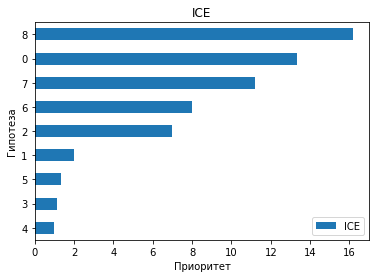

In [8]:
def priotize(method):
    ax = hypothesis[['hypothesis', method]].sort_values(method, ascending=True).plot(kind='barh')
    ax.set_xlabel('Приоритет')
    ax.set_ylabel('Гипотеза')
    ax.set_title(method)
    plt.show()
priotize('ICE')

In [9]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values('RICE',ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


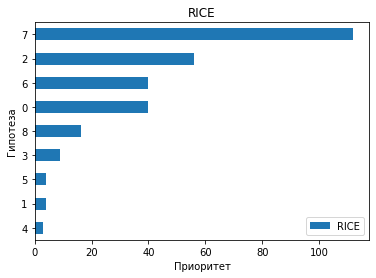

In [10]:
priotize('RICE')

### Вывод

<b>Приоритизация</b>
<table style="float:left;clear:both;display:block;">
  <thead>
    <tr>
      <td style="text-align: left;"><b>ICE</b></td>
      <td style="text-align: left;"><b>RICE</b></td>
    </tr>
  </thead>
  <tr>	
    <td style="text-align: left;">8</td>
    <td style="text-align: left;">7</td>
  </tr>    
  <tr>
    <td style="text-align: left;">0</td>
    <td style="text-align: left;">2</td>
  </tr>
  <tr>
    <td style="text-align: left;">7</td>
    <td style="text-align: left;">0</td>
  </tr>
  <tr>
    <td style="text-align: left;">6</td>
    <td style="text-align: left;">6</td>
  </tr>
  <tr>
    <td style="text-align: left;">2</td>
    <td style="text-align: left;">8</td>
  </tr>
</table>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
Приоритизация гипотез при применении RICE в отличии от ICE сильно отличается. Дело в том, что формулы разные, RICE учитывает параметр Reach (охват пользователей).

<a id='step_4'></a>
## 4. Анализ A/B-теста:

<a id='step_41'></a>
### 4.1 Кумулятивная выручка по группам

In [11]:
orders.head(5)
visitors.head(5)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
datesGroups = pd.DataFrame(orders[['date','group']]).drop_duplicates()

ordersAggregated  = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
    'date' : 'max',
    'group' : 'max',
    'transaction_id' : pd.Series.nunique,
    'visitor_id' : pd.Series.nunique,
    'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
    'date' : 'max', 
    'group' : 'max', 
    'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [13]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


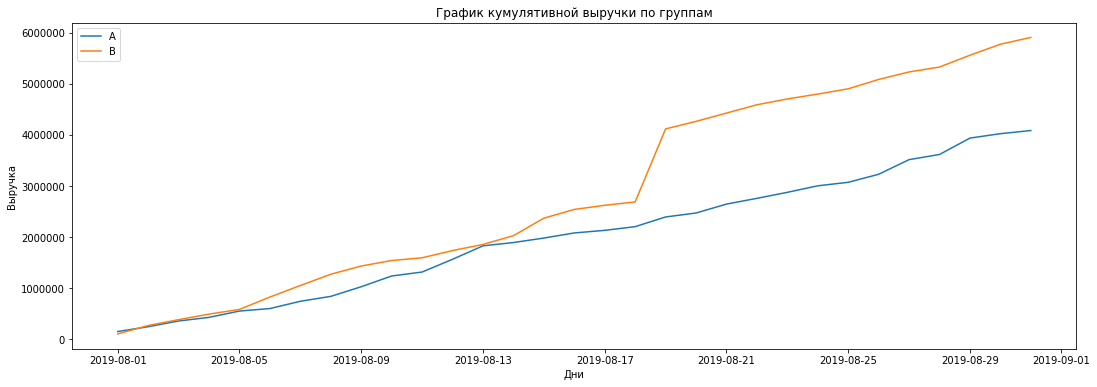

In [14]:
figure(figsize=(18, 6))

#Устранил предупреждение при выводе данных
pd.plotting.register_matplotlib_converters()

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка")
plt.plot(figsize=(16,8))
#fix_2
plt.xlabel("Дни")
plt.legend();

В период с 18.09.19 по 19.09.19 резкий скачок похожий на выброс. Выручка группы B выше чем у A, даже несмотря на скачок. Графики растут линейно и не стабилизровались под конец периода. Это говорит о том, что нужно больше данных, чтобы прийти к реальному среднему значению.

<a id='step_42'></a>
### 4.2 Кумулятивный средний чек по группам

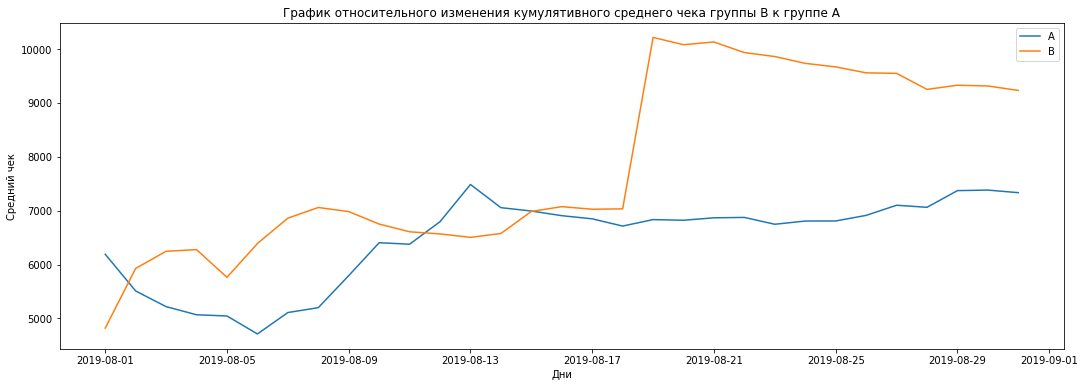

In [15]:
figure(figsize=(18, 6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

#fix_2
plt.ylabel("Средний чек")
plt.xlabel("Дни")
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.legend();

На этом графике тот же самый скачок.

<a id='step_43'></a>
### 4.3 Относительное изменение кумулятивного среднего чека группы B к группе A

In [1]:
figure(figsize=(18, 6))

# собираем данные в одном датафрейме
mergedCumRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumRevenue['date'],
         (mergedCumRevenue['revenueB']/mergedCumRevenue['ordersB'])\
         /(mergedCumRevenue['revenueA']/mergedCumRevenue['ordersA'])-1);

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');#fix_2

NameError: name 'figure' is not defined

Скачок виден и здесь.

<a id='step_44'></a>
### 4.4 Кумулятивная конверсия по группам

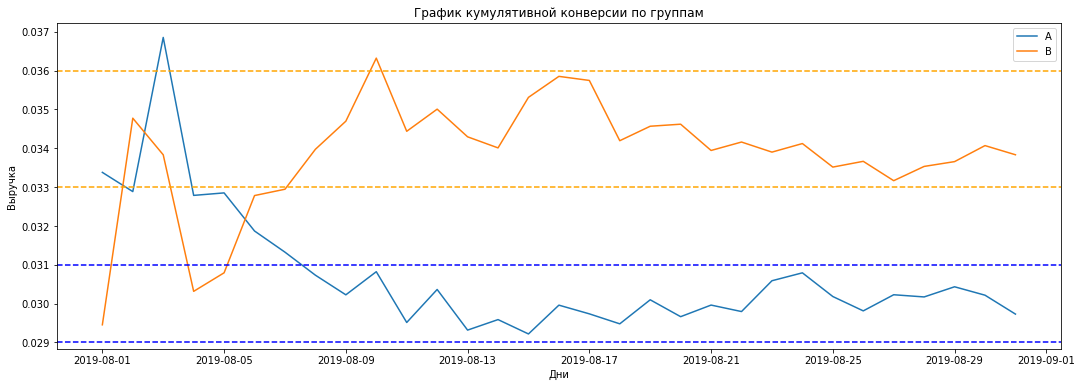

In [17]:
# считаем кумулятивную конверсию
figure(figsize=(18, 6))
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('График кумулятивной конверсии по группам')
plt.ylabel("Выручка")
plt.xlabel("Дни")
plt.axhline(y=0.036, color='orange', linestyle='--')
plt.axhline(y=0.033, color='orange', linestyle='--') 
plt.axhline(y=0.031, color='blue', linestyle='--')
plt.axhline(y=0.029, color='blue', linestyle='--')
plt.legend();#fix_2

После скачков выручка обоих групп в пределах 3 делений, у B от 0.033 до 0.036, а у А от 0.029 до 0.031.

<a id='step_45'></a>
### 4.5 Относительное изменение кумулятивной конверсии группы B к группе A

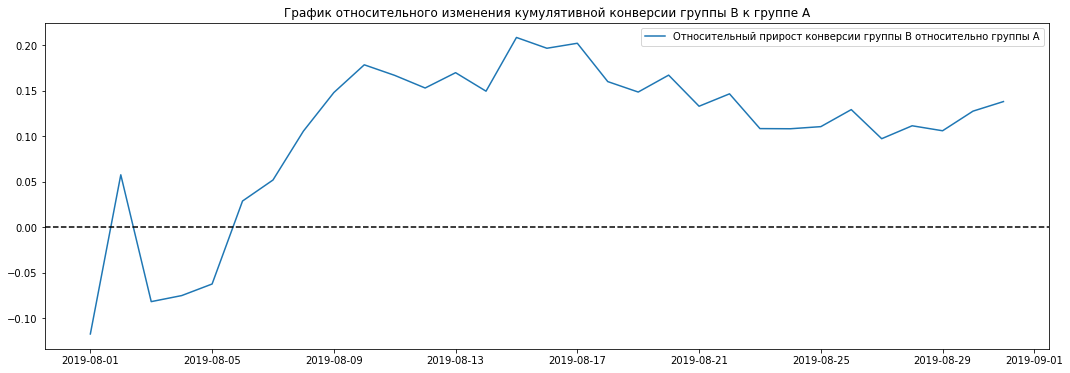

In [18]:
figure(figsize=(18, 6))

mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
         label="Относительный прирост конверсии группы B относительно группы A")

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend();#fix_2

### Вывод

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Все три графика демонстрируют скачок в период с 18.09.19 по 19.09.19. Нужно проверить выбросы. Графики растут линейно. Данных в целом мало, поэтому графики не стабилизировались, нужно большей значений.

## Точечные графики

<a id='step_51'></a>
### 5.1 Точечный график количества заказов по пользователям

In [19]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1)\
    .groupby('visitor_id', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique})
ordersByUsers.columns = ['visitor_id','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


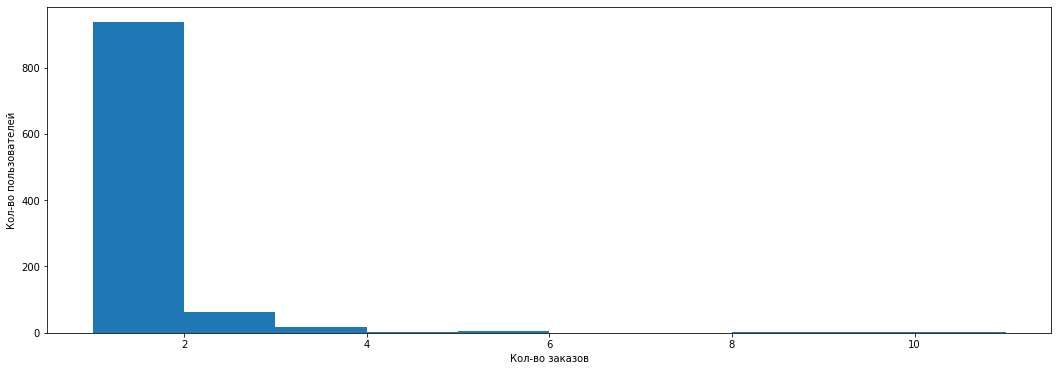

In [87]:
figure(figsize=(18, 6))
plt.hist(ordersByUsers['orders']) 

#fix_2
plt.ylabel("Кол-во пользователей")
plt.xlabel("Кол-во заказов");

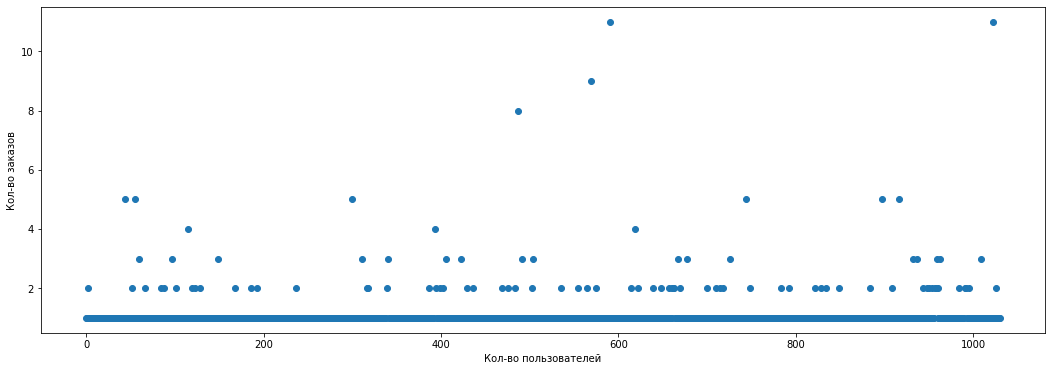

In [88]:
figure(figsize=(18, 6))
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0,len(ordersByUsers)))

#fix_2
plt.ylabel("Кол-во заказов")
plt.xlabel("Кол-во пользователей");
plt.scatter(x_values, ordersByUsers['orders']);

Подавляющее большинство пользователей покупают 1 раз, но так же есть и покупатели, кто делает покупки периодически. Всё что выше 4 аномально.

<a id='step_52'></a>
### 5.2 Перцентили количества заказов на пользователя

In [22]:
# Метод np.percentile('column', [percentile1, percentile2, percentile3]) находит перцентили.
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 


[1.00 2.00 4.00]


Значения больше 99 перцентиля аномальны.

<a id='step_53'></a>
### 5.3 Точечный график стоимостей заказов

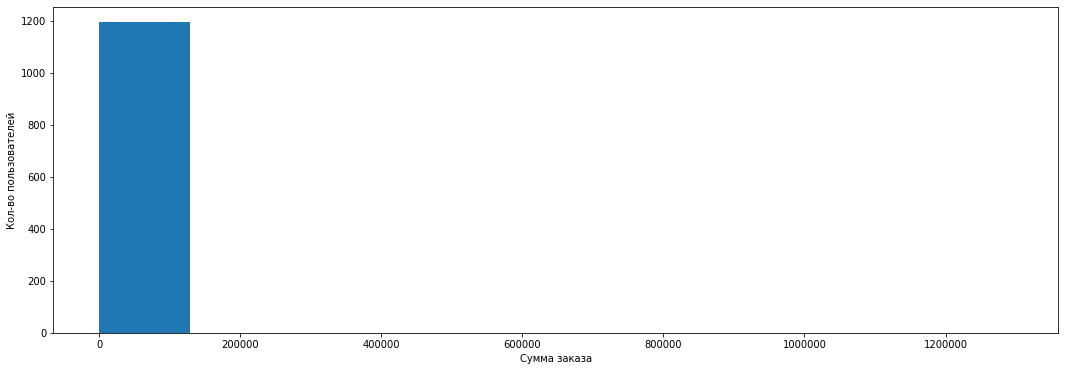

In [89]:
figure(figsize=(18, 6))
#fix_4
plt.hist(orders['revenue'])
plt.ylabel("Кол-во пользователей")
plt.xlabel("Сумма заказа");

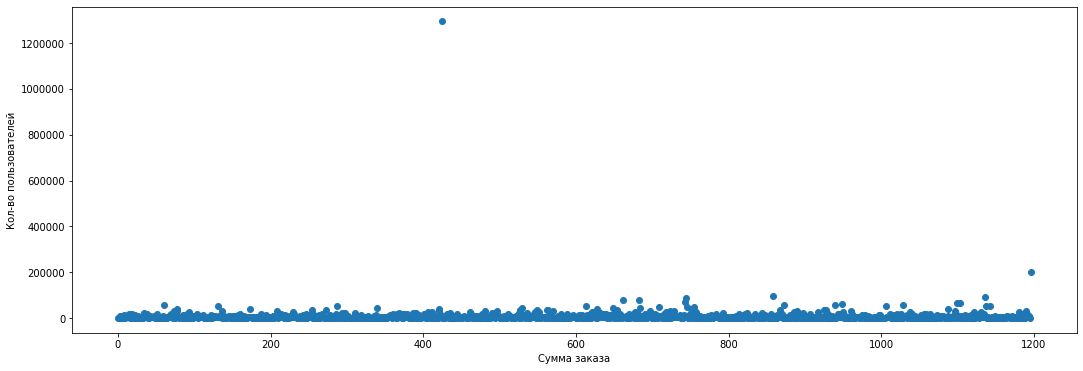

In [90]:
figure(figsize=(18, 6))
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.ylabel("Кол-во пользователей")
plt.xlabel("Сумма заказа")
plt.scatter(x_values, orders['revenue']);

Видны два выброса.

<a id='step_54'></a>
### 5.4 Перцентили стоимости заказов

In [25]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.00 28000.00 58233.20]


Не более, чем у 5% заказов чек дороже 28000. И не больше, чем у 1% заказов — дороже 58233. Всё, что больше 58233 можно считать аномальным. 

### Вывод

Нашел 1% аномалий: у количества заказов это всё, что больше 4 заказов, а у стоимости - всё, что дороже 58233.

<a id='step_6'></a>
## 6. Проверка гипотез

<a id='step_61'></a>
### 6.1 Статистическая значимость различий в конверсии между группами

In [43]:
import scipy.stats as stats
from scipy import stats as st

visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date' : 'max',
         'visitorsPerDateA' : 'sum'}),
    axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date' : 'max',
         'visitorsPerDateB' : 'sum'}),
    axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders[orders['group']=='A'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,20,148579,20,101217,20,148579,20,101217,719,713,719,713
1,2019-08-02,19,93822,23,165531,39,242401,43,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,63,354874,59,380996,507,509,1845,1803
3,2019-08-04,15,70825,16,108571,78,425699,75,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,103,549917,98,581995,756,707,3318,3280


In [41]:
conversion = (orders.groupby('group').agg({'transaction_id':'count'}).rename(columns={'transaction_id':'orders'}))\
                                     .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()
conversion['conversion'] = conversion['orders'] / conversion['visitors']
conversion

,group,orders,visitors,conversion
0,A,557,18736,0.029729
1,B,640,18916,0.033834


Воспользуемся z-критерием Фишера.<br>
Нулевая гипотеза: Конверсия в группе A равна конверсии в группе B<br>
Альтернативная: Конверсия в группе A не равна конверсии в группе B

In [44]:
alpha=0.05
purchases = np.array(conversion['orders'])
leads = np.array(conversion['visitors'])
p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / math.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = st.norm(0,1)

pvalue = stats.mannwhitneyu(sampleA, sampleB)[1]

#fix_7
print('p-значение: ', pvalue)
print("Прирост конверсии: {:.1f}%".format((sampleB.mean()/sampleA.mean()-1)*100))
print('')
if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

p-значение:  0.008396177528376304
Прирост конверсии: 13.8%

Отвергаем нулевую гипотезу.


Первое число — p-value = 0.008, что меньше 0.05. Значит, отвергаем нулевую гипотезу о том, что статистически значимые различия в конверсии между группами отсутствуют. Также относительный выигрыш группы B к группе А равен 13.8%. 

<a id='step_62'></a>
### 6.2 Статистическая значимость различий в среднем чеке заказа между группами 

Воспользуемся критерием Манна-Уитни.<br>
Нулевая гипотеза: Средний чек A не превышает средний чека группы B<br>
Альтернативная: Средний чек A превышает средний чека группы B

In [34]:
#fix_7
pvalue = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print('p-значение: ', pvalue)
print("Прирост конверсии: {:.1f}%".format(
    (orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)*100))
print()
if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима.")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя.")

p-значение:  0.3646454927716229
Прирост конверсии: 25.9%

Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя.


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B выше среднего чека группы А на 25.9%.

<a id='step_63'></a>
### 6.3 Статистическая значимость различий в конверсии между «очищенными» группами 

In [58]:
#Отфильтровал данные из расчётов 99-го перцентиля.
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 4]['visitor_id'],
                                 ordersByUsersB[ordersByUsersB['orders'] > 4]['visitor_id']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295 
949     887908475 
744     888512513 
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64
(15,)


Отсеяно 15 выбросов.

In [97]:
orders_temp = orders[~orders['visitor_id'].isin(abnormalUsers)]
conversion_clear = (orders_temp.groupby('group').agg({'transaction_id':'count'}).rename(columns={'transaction_id':'orders'}))\
                                                .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()

Воспользуемся z-критерием Фишера.<br>
Нулевая гипотеза: Конверсия в группе A равна конверсии в группе B<br>
Альтернативная: Конверсия в группе A не равна конверсии в группе B

In [101]:
purchases = np.array(conversion_clear['orders'])
leads = np.array(conversion_clear['visitors'])

p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]

combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / math.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = st.norm(0,1)

p_value = (1 - distr.cdf(abs(z_value))) * 2
#fix_7
print('p-значение: ', pvalue)
print("Прирост конверсии: {:.1f}%".format(
    ((sampleBFiltered.mean()/sampleAFiltered.mean()-1))*100))
print()
if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

p-значение:  0.007190067792654007
Прирост конверсии: 15.3%

Отвергаем нулевую гипотезу.


Результаты конверсии почти не изменились. P-value меньше 0.05, отвергаем нулевую гипотезу. Разница между сегментами увеличилась с 14.6% до 15.3%

<a id='step_64'></a>
### 6.4 Статистическая значимость различий в среднем чеке заказа между группами 

Воспользуемся критерием Манна-Уитни.<br>
Нулевая гипотеза: Средний чек A не превышает средний чека группы B<br>
Альтернативная: Средний чек A превышает средний чека группы B

In [102]:
#fix_7
pvalue = stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])[1]
    
print('p-значение: ', pvalue)
print("Прирост конверсии: {:}".format(
    orders[np.logical_and(
        orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 
print()
if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима.")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя.")

p-значение:  0.42545630956909697
Прирост конверсии: -0.005748871952734214

Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя.


P-value увеличился, статистически значимых различий по конверсии после фильтрации аномалий нет. Однако прилично изменился средний чек группы B, который стал ниже группы А с разницей ~26% до фильтрации.

### Вывод
* Нет статистически значимого различия по конверсии как между группами сырых данных, так и между группами после фильтрации аномалий.
* По сырым данным нет статистически значимого различия по среднему чеку между группами ни до ни после фильтрации аномалий.
* Результаты различия конверсии группы B лучше группы A и имеют тенденцию к росту.
* Результаты различия среднего чека группы B ухудшились, группа А в незначительном выигрыше. Тем не менее вывод сделать нельзя.

<a id='step_7'></a>
## Общий вывод

#### Приоритизация гипотез
Состав топ-5 гипотез по обоим фреймворкам (ICE и RICE) получился одинаковым. В приоритете лучше использовать RICE, так как он учитывает охват пользователей:
    1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок 
    2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа 
    3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
    4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
    5. Запустить акцию, дающую скидку на товар в день рождения

#### A/B-тест
Результаты не однозначны. У группы Б есть перспектива победить, но данных, чтобы утверждать это мало. Поэтому тест нужно продолжить, пока не соберем больше наблюдений.